<a href="https://colab.research.google.com/github/sigmunjr/TEK5030_deep_learning/blob/master/TEK5030_deep_learning_EX1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1: Simple Convolutional Neural network (CNN)

In this execrise you are building a neural network to separate between cats and dogs. If you want, you can also try separating different breeds.

## Dataset
We will use [Tensorflow Datasets](https://www.tensorflow.org/datasets) in this exercise. This makes it fast and easy to download and get started. You can also input numpy arrays directly or build your own data pipelines using [tf.data](https://www.tensorflow.org/guide/data).

We use the [oxford_iiit_pet](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet) dataset, that provide images of dogs and cats and labels that say whether it is a cat or a dog, the breed of the animal and a segmentation mask.

### Loading and preprocessing the data
A [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) has serveral transform functions. We use [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to extract only the data we want and preprocess the images. We resize the images for faster processing and subtrackt 1 from input mask to get the values [0, 1].



In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

tfds.disable_progress_bar()

def load_image(datapoint):
  input_image = tf.cast(tf.image.resize(datapoint['image'], (128, 128)), tf.float32) / 255.
  input_mask = tf.math.minimum(tf.image.resize(
      tf.cast(datapoint['segmentation_mask'], tf.int64), (128, 128), 'nearest'
      ) - 1, 1)
  print('Data in datapoint:', list(datapoint.keys()))

  return input_image, input_mask, datapoint['species']

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
train_data = dataset['train'].map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data = dataset['test'].map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteEQSRDD/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteEQSRDD/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0. Subsequent calls will reuse this data.


TypeError: ignored

### Visualizing the data
You should always inspect the data your using as training data, to get a feeling for the problem. 

Her we print the plot the image, the mask and its label.

**TODO:** Print the type of animal and not just the number for each image.

In [0]:
def display(display_list, titles=None):
  """ Plotting images in list """
  from matplotlib import cm
  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    if titles != None:
      plt.title(titles[i])
    plt.imshow(
        tf.keras.preprocessing.image.array_to_img(display_list[i]),
        vmin=0,
        vmax=1
        )
    plt.axis('off')
  plt.show()

for image, mask, label in train_data.take(4):
  # TODO: Print tekst string with animal type.
  display([image, mask])

### Nearest neighbors in pixel space

For fun we can check out which images are close in pixel space. This means we will find images with similar colored pixels in the same location. Often generally dark images will match with dark images and visa-versa. This makes it clear that we cannot separate cat and dogs with a shallow classification algorithm in pixel space directly.

In [0]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot


import numpy as np


# Pick the first 200 samples and take only the images of each sample
only_images_dataset = train_data.take(400).map(lambda img, i1, i2: img)

# Extract the images to a numpy array of the 400 images of shape 200x128x128x3
X = np.array(list(only_images_dataset.as_numpy_iterator()))

nbrs = NearestNeighbors(n_neighbors=3)
# Add images reshaped to vectors to nearest-neighbors tree
nbrs.fit(X.reshape([X.shape[0], -1]))

# Loop through 10 test images and display 3 nearest neighbors
for image, mask, label in test_data.shuffle(100).take(10):
  distances, indices = nbrs.kneighbors(image.numpy().reshape((1, -1)))
  show_img = display([
                      image.numpy(),
                      X[indices[0, 0]],
                      X[indices[0, 1]],
                      X[indices[0, 2]]
                      ], ['Image'] + list(distances[0]))

## Fully-convolutional network
It's a good idea to implement the network as a fully-convolutional neural network. This means that the network will work for all input sizes.

A fully-convolutional network use no fully-connected layers (matrix multiplications). They often consist of mostly convolutional layers, but also include other operations that does not require fixed input size like: add, concatenations, max (relu), batch normalization etc.

## Keras model
I recommend using the Object-Oriented style of Keras, as it is the most flexible and are almost identical in both Keras/Tensorflow and PyTorch. In this approach you make subclass of [tensorflow.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) and implement the **\_\_init\_\_** and **call** method. In **\_\_init\_\_** you need to initialize everything that has state in your network, while **call** method actually run the network from output to input.

**TODO:**
Fill out the *\_\_init\_\_* and *call* method with convolutional layers and use the [*ReLU*](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) as activation function.

The output of the *call* function should have shape \[*batch_size*, *num_classes*\].

**If the "output_features" parameter is *True* you should output the result before the last convolutioal layer.**

*HINT: You can use [tf.math.reduce_mean](https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean) to sum over the spatia* dimension.

In [0]:
import time

import cv2
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dense, Dropout


class SimpleNet(Model):
    def __init__(self, num_classes=10):
        super(SimpleNet, self).__init__()
        self.num_classes = num_classes
        # TODO: Initialize the layers of your network
        # You can find different layers in tensorflow.keras.layers (https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers)

    def call(self, x, visualise=False, output_features=False, training=False):
        # TODO: Run the image through your network
        # Your input should be a [Batch_size x 3 x 32 x 32] sized tensor
        # Your output should be a [Batch_size x num_classes] sized matrix

        # Output features of your second last layer
        if output_features: return x

        # Return the result of your network
        return tf.math.reduce_mean(x, axis=(1, 2))

# Initializing the model
NUM_CLASSES = 5
BATCH_SIZE = 8
model = SimpleNet(NUM_CLASSES)
# Running the model with 8 random 128x128x3 images
model_output = model(np.random.random((BATCH_SIZE, 128, 128, 3)).astype(np.float32))
print('Model output:', model_output)
print('Model output shape:', model_output.shape)

assert model_output.shape == (BATCH_SIZE, NUM_CLASSES), "Incorrect output size from call"

### Training a Keras model
There is basically two different methods of training a Tensorflow-Keras model. 

One is **simple** method is just calling the models [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) and [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) functions. This is simple and makes sure everything is handled properly, but it leaves the control to Keras, so making changes in the training process can only be done by providing a list of [callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) to **fit**.

For the second method you take control over the training process yourself. You can check out [this guide](https://www.tensorflow.org/tutorials/quickstart/advanced) for a good example. Here there are three fundemental steps to you training: Creating an optimizer, run model to extract gradients and apply gradients.

Creating an optimizer
    
    optimizer = tf.keras.optimizers.Adam()

Run model to extract gradients

    with tf.GradientTape() as tape:
      loss = model(input)
    
Running the model inside the GradientTape scope stores the gradients in "tape".

Apply gradients

    # Get gradients of loss with respect to the trainable_variables
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # Run optimization step following the optimizers scheme
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

This second method is good for debuging or if you need some specialized form of training. For larger projects i recommend implementing both ways of training, one for debuging and one for running.

#### **Tips for training**
Start by training your network with just a small dataset, e.g. one batch. 

To check you have properly initialized your weights and scaled your inputs you can check your initial loss. Your initial loss should be roughly equal to *-ln(1/N)*, where N is the number of classes.

When training on a small version of your dataset your accuracy should steadily rise to 1. If it does not, you could try to adjust your learning rate. Your learning rate should generally be as high as possible, while still not increase your loss at the begining of your training.

Adam is often a good optimizer for quick tests, as it requires comparably less *tuning* of the learning rate.

**TODO**:
Train the network to a decent test accuracy. The dataset are small so we cannot expect very good accuracy, but you should at least expect 0.72 test accuracy.

I recommend using the **model.fit** approach to train your model, if you are inexperienced.

In [0]:
train_ds = train_data.map(lambda img, mask, label: (img, label)).shuffle(256, reshuffle_each_iteration=True)
test_ds = test_data.map(lambda img, mask, label: (img, label))

#TODO: Initialize and train your network


### Visualizing nearest neighbor in feature space

The neural network transforms the input so that cats and dogs can be separated. Generally ths will make cat be close to cats and dogs be close to dogs. We can often also see that close object share some characteristics.

In [0]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot


import numpy as np
# Pick the first 200 samples and take only the images of each sample
only_images_dataset = train_data.take(400).map(lambda img, i1, i2: img)
images_np = only_images_dataset.batch(400).__iter__().__next__().numpy()

# Extract the images to a numpy array of the 200 images of shape 200x128x128x3
X = model(images_np, output_features=True).numpy()


nbrs = NearestNeighbors(n_neighbors=3)
# Add images reshaped to vectors to nearest-neighbors tree
print('XSHAPE', X.shape)
nbrs.fit(X.reshape([X.shape[0], -1]))

# Loop through 10 test images and display 3 nearest neighbors
for image, mask, label in test_data.shuffle(1000).take(20):
  distances, indices = nbrs.kneighbors(model(image[tf.newaxis], output_features=True).numpy().reshape((1, -1)))
  show_img = display([
                      image.numpy(),
                      images_np[indices[0, 0]],
                      images_np[indices[0, 1]],
                      images_np[indices[0, 2]]
                      ], ['Image'] + list(distances[0]))

### Visualizing [GRAD-CAM](http://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf)

There are many techniques for visualizing what is going on inside a neural network.

The technique use the gradients of the output label with respect to the image in combination with the values of the activation map. With this information we can plot what regions of the input that are pointing toward a given label.

We would e.g. expect that a cat would light up if we used the cat label for as input to Grad-CAM.

With this technique we can check if the network actually use relvant information in the classification process and are not overfitted.

Since the output is normalized, it will always highlight some regions. If the surroundings is highlighted it may simply mean that it found nothing "doglike" in the image.

In [0]:
#Install the visualization tool
!pip install tf-keras-vis

Estimated DOG with probability: 0.8723093
Estimated DOG with probability: 0.8723093


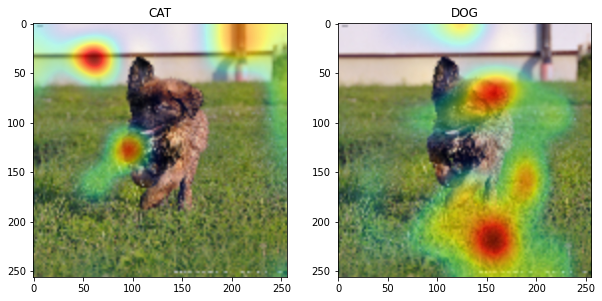

Estimated CAT with probability: 0.7623905
Estimated CAT with probability: 0.7623905


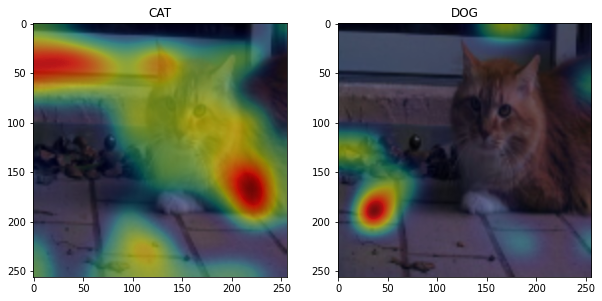

Estimated DOG with probability: 0.9344126
Estimated DOG with probability: 0.9344126


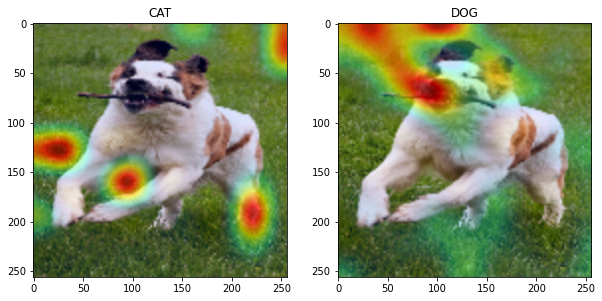

Estimated DOG with probability: 0.9855769
Estimated DOG with probability: 0.9855769


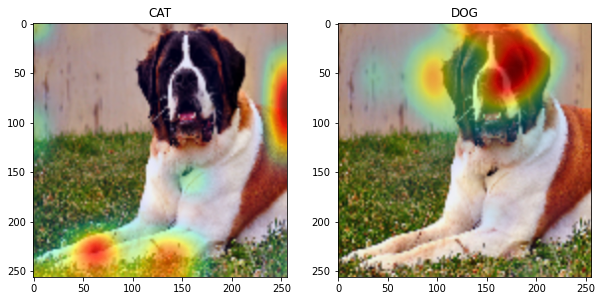

Estimated DOG with probability: 0.54587525
Estimated DOG with probability: 0.54587525


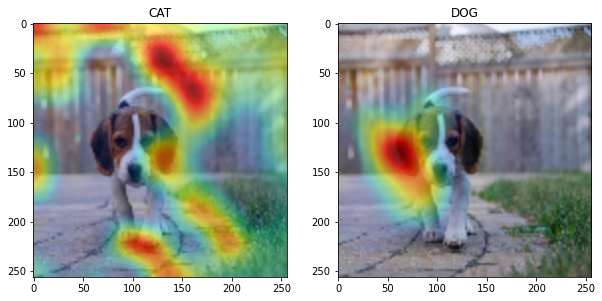

Estimated DOG with probability: 0.77446604
Estimated DOG with probability: 0.77446604


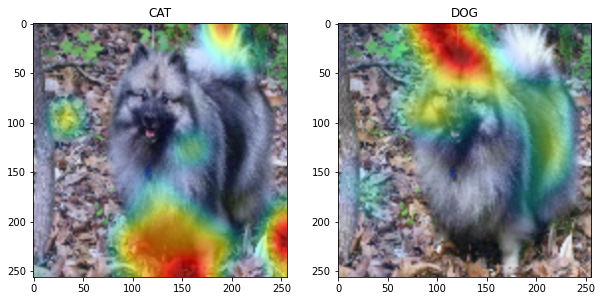

Estimated DOG with probability: 0.59060246
Estimated DOG with probability: 0.59060246


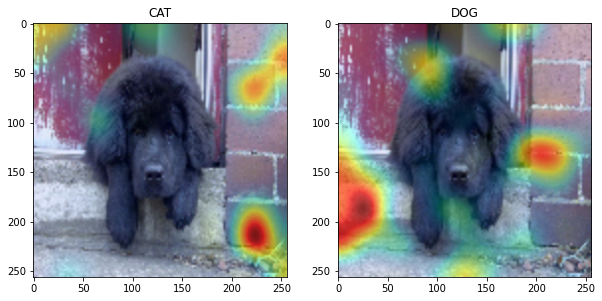

Estimated CAT with probability: 0.5928167
Estimated CAT with probability: 0.5928167


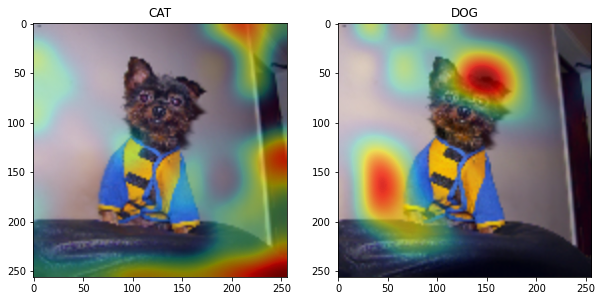

Estimated CAT with probability: 0.7615682
Estimated CAT with probability: 0.7615682


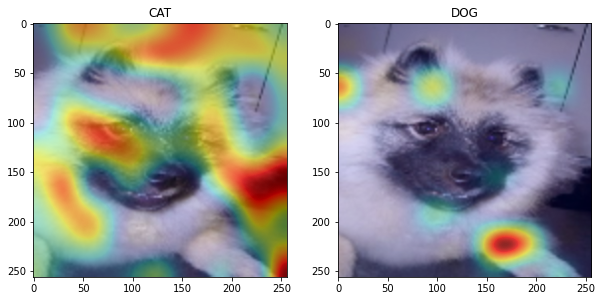

Estimated CAT with probability: 0.5332614
Estimated CAT with probability: 0.5332614


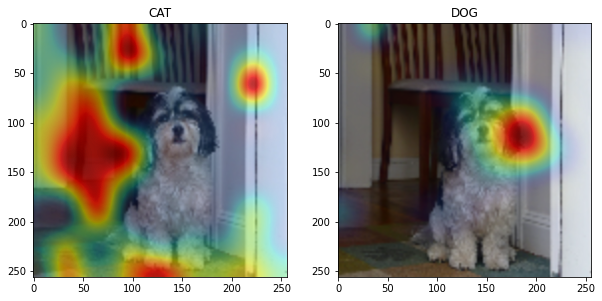

Estimated DOG with probability: 0.6037039
Estimated DOG with probability: 0.6037039


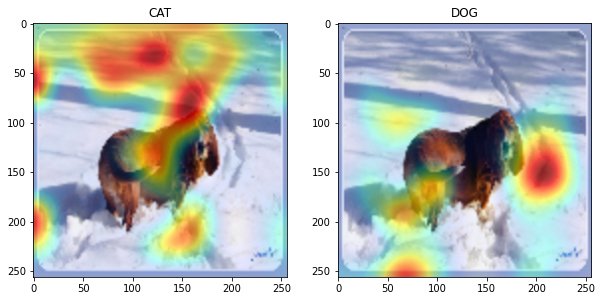

Estimated DOG with probability: 0.64511687
Estimated DOG with probability: 0.64511687


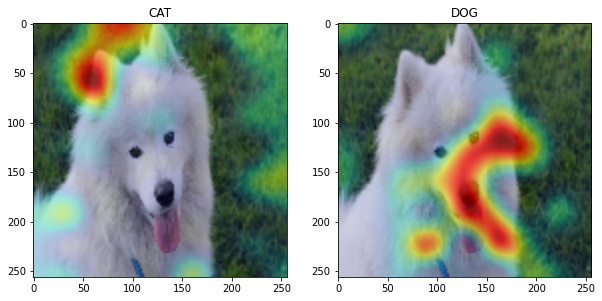

Estimated DOG with probability: 0.5034491
Estimated DOG with probability: 0.5034491


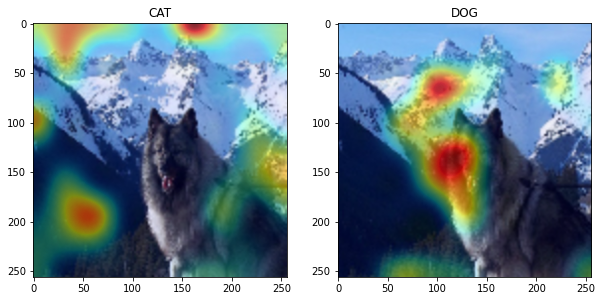

Estimated CAT with probability: 0.5883085
Estimated CAT with probability: 0.5883085


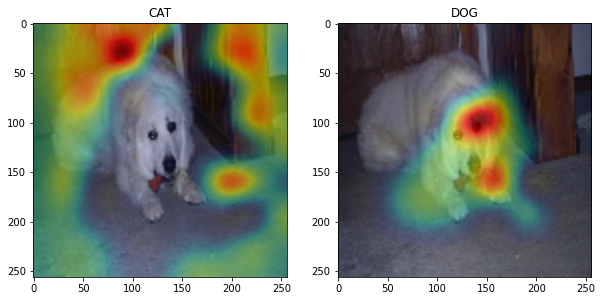

Estimated DOG with probability: 0.5024672
Estimated DOG with probability: 0.5024672


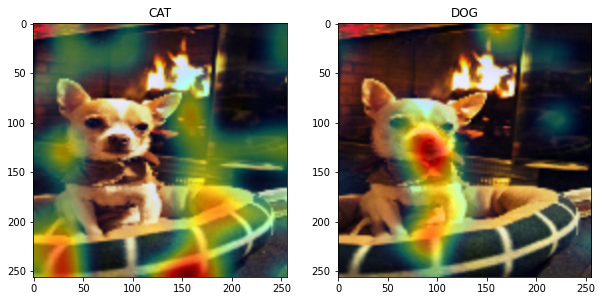

Estimated CAT with probability: 0.72337127
Estimated CAT with probability: 0.72337127


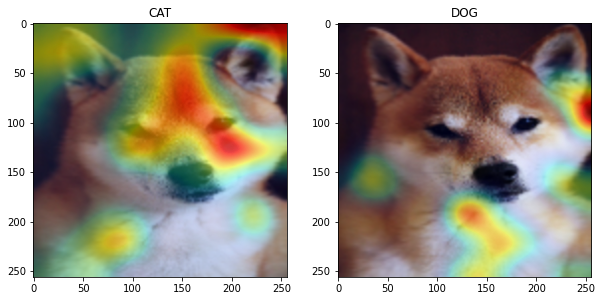

Estimated DOG with probability: 0.97548
Estimated DOG with probability: 0.97548


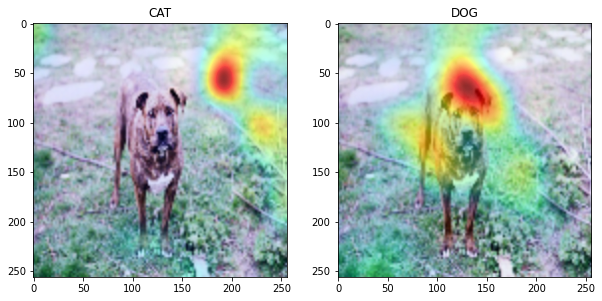

Estimated DOG with probability: 0.58776706
Estimated DOG with probability: 0.58776706


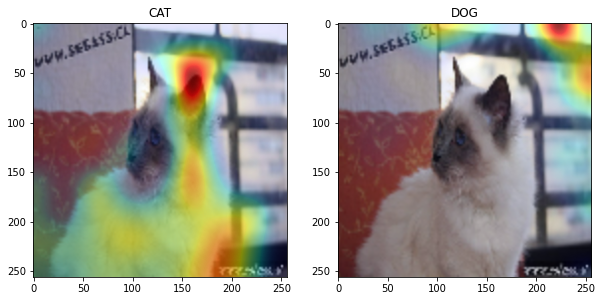

Estimated CAT with probability: 0.74771506
Estimated CAT with probability: 0.74771506


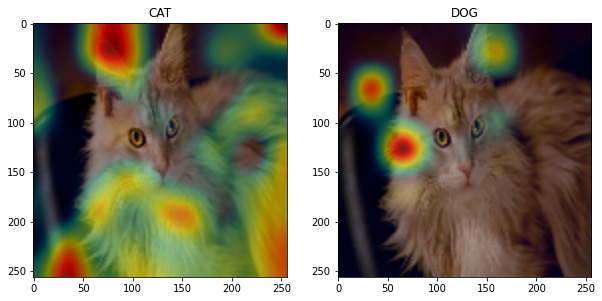

Estimated DOG with probability: 0.93986183
Estimated DOG with probability: 0.93986183


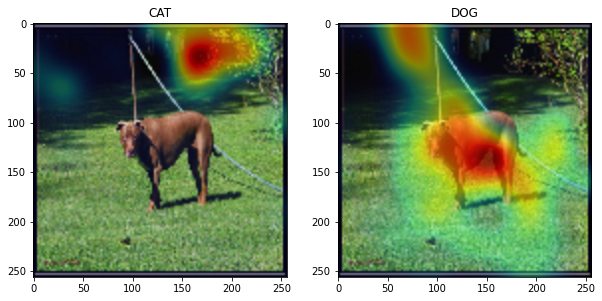

In [0]:
from vis.utils import utils
from tf_keras_vis.gradcam import Gradcam
import numpy as np
from tensorflow.keras import layers, models
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

def convert_to_functional_model(model):
  input_layer = layers.Input(batch_shape=[1, 128, 128, 3])
  prev_layer = input_layer

  def iterate_model_layers(model, prev_layer):
    for layer in model.layers:
      prev_layer = layer(prev_layer)
    return prev_layer

  prev_layer = iterate_model_layers(model, prev_layer)
  return models.Model([input_layer], [prev_layer])

def plot_gradcam_for_layer(ax, image, label):
  label_map = ['CAT', 'DOG']
  def loss(output):
    area_mean = tf.math.reduce_mean(output, axis=[0, 1, 2])
    estimated_label = tf.argmax(area_mean)
    print('Estimated', label_map[estimated_label],
          'with probability:', tf.nn.softmax(area_mean)[estimated_label].numpy())
    return area_mean[label]

  image = tf.image.resize(image[tf.newaxis], [256, 256])
  cam = gradcam(loss, image, penultimate_layer=7)
  #Normalize output
  cam -= cam.min()
  cam /= cam.max() if cam.max() > 0. else 1.0 

  ax[label].set_title(label_map[label])
  ax[label].imshow(image[0])
  ax[label].imshow(cam[0], cmap='jet', alpha=0.8*cam[0])

# We need to convert the model to functional graph to use tf-keras-vis
funcmodel = convert_to_functional_model(model)

#Create gradcam for model
gradcam = Gradcam(funcmodel)

for image, mask, label in test_data.take(20):
  f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
  plot_gradcam_for_layer(ax, image, 0)
  plot_gradcam_for_layer(ax, image, 1)
  plt.show()

### Finetuning a network
You can quite easily download and run a pretrained network. Using a network that is trained on a similar, but larger dataset will often improve your result. Using a network pretrained on the ImageNet dataset will definetly work, as the dataset already includes different types of dogs and cats.

You can e.g. load a pretrained network like this:

    from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
    net = MobileNetV2(weights='imagenet', include_top=False)

Here we exclude the top classification layer, as we want a different number of classes. So we have to make this layer for our self.

Now the network can be used similar to a Conv2D layer. If you have a small dataset or few computational resourses, you can freeze the network parameters in the pretrained network like this:

    net.trainable = False

**TODO:**
Use a pretrained network as a start of your model, but make a few convolutional layers for yourself. Train only the last layers.

In [0]:
import time

import cv2
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model
import tensorflow.keras as keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, Dense, Dropout
import tensorflow_hub as hub


class FinetuneNet(Model):
    def __init__(self, num_classes=10):
        super(FinetuneNet, self).__init__()
        self.num_classes = num_classes
        # TODO: Initialize the layers of your network
        # You can find different layers in tensorflow.keras.layers (https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers)

    def call(self, x, visualise=False, output_features=False, training=False):
        # TODO: Run the image through your network
        # Your input should be a [Batch_size x 3 x 32 x 32] sized tensor
        # Your output should be a [Batch_size x num_classes] sized matrix
        if output_features: return x
        # Return the result of your network
        return tf.math.reduce_mean(x, axis=(1, 2))

# Initializing the model
NUM_CLASSES = 5
BATCH_SIZE = 8
model2 = FinetuneNet(NUM_CLASSES)
# Running the model with 8 random 128x128x3 images
model_output = model2(np.random.random((BATCH_SIZE, 128, 128, 3)).astype(np.float32))
print('Model output:', model_output)
print('Model output shape:', model_output.shape)

assert model_output.shape == (BATCH_SIZE, NUM_CLASSES), "Incorrect output size from call"

**TODO:**

Train your new network.

This should give a lot better performance, at least 0.9 in test accuracy!

You can re-run the visualization code, with this model. This should give a better clustering of dog and cats, and even cluster different breeds.

**TODO:** Initialize and finetune your model

In [0]:
# TODO: Initialize and finetune your model